In [ ]:
!pip install binance-connector

In [39]:
import requests
import pandas as pd
from binance.spot import Spot
import seaborn as sns
import matplotlib.pyplot as plt

# Question 1: Use python to collect historical BTC/USD prices of the ccix index for the last 30 days using the following endpoint

In [2]:
url = 'https://data-api.cryptocompare.com/index/cc/v1/historical/days?market=ccix&instrument=BTC-USD&limit=30&aggregate=1&fill=true&apply_mapping=true&response_format=JSON'
response = requests.get(url).json()
data = response['Data']

In [11]:
# Calculating daily returns (opening price vs closing price)

# For each day, work out the closing price - opening price

def df_from_pricing(data):
    price_df = pd.DataFrame(data=data)
    price_df['daily_returns'] = price_df['CLOSE'] - price_df['OPEN']
    return price_df

ccdata_df = df_from_pricing(data)

average = ccdata_df['daily_returns'].mean()
median = ccdata_df['daily_returns'].median()
std = ccdata_df['daily_returns'].std()

# Question 2: 

In [76]:
# Using CCdata's API to retreive the same data from Binance specifically

url2 = 'https://data-api.cryptocompare.com/spot/v1/historical/days?market=binance&instrument=BTC-USDT&limit=30&aggregate=1&fill=true&apply_mapping=true&response_format=JSON'
response2 = requests.get(url2).json()
data2 = response2['Data']

In [13]:
binance_df = df_from_pricing(data2)

In [ ]:
# Using Binance's API to get the same data

In [77]:
client = Spot()
binance_api_data = client.klines("BTCUSDT", "1d", limit=30)

In [78]:
binance_api_data_list = []
label_list = ['TIMESTAMP','OPEN','HIGH','LOW','CLOSE','VOLUME','close_time','QUOTE_VOLUME','TOTAL_TRADES']
for day in binance_api_data:
    day_dict = {}
    for index, label in enumerate(label_list):
        day_dict[label] = float(day[index])
    binance_api_data_list.append(day_dict)

In [79]:
binanceapi_df = df_from_pricing(binance_api_data_list)

In [ ]:
# One clear difference is that one is counting the timestamp in seconds (CCData), and one in milliseconds (Binance)

In [51]:
binanceapi_df['TIMESTAMP'] = binanceapi_df['TIMESTAMP']/1000

In [58]:
binanceapi_df['TIMESTAMP'].describe() - binance_df['TIMESTAMP'].describe()

count    0.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: TIMESTAMP, dtype: float64

In [60]:
for column in binanceapi_df.columns:
    if column in binance_df.columns:
        print(f'Discrepency for {column}. Positive values are Binance API:')
        print(binanceapi_df[column].describe() - binance_df[column].describe())
        print(' ')

Discrepency for TIMESTAMP:
count    0.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: TIMESTAMP, dtype: float64
 
Discrepency for OPEN:
count    0.000000
mean     0.000333
std      0.000440
min      0.010000
25%     -0.007500
50%     -0.005000
75%     -0.007500
max     -0.010000
Name: OPEN, dtype: float64
 
Discrepency for HIGH:
count    0.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: HIGH, dtype: float64
 
Discrepency for LOW:
count    0.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: LOW, dtype: float64
 
Discrepency for CLOSE:
count    0.000000
mean     1.251333
std     -0.782017
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      0.000000
Name: CLOSE, dtype: float64
 
Discrepency for VOLUME:
count     0.000000
mean     21.276874
std     -11.375838
min       0.000000
25%       0.000000
50%       0.0000

Notes on the discrepancies:
- Timestamp, high and low are all equivalent, implying there is no issue with time zones or actual like-for-like pricing, though there could be specific prices which are incorrect due to other differences
- Volume is negligible compared to overall values.
- Largest discrepancy is in QUOTE_VOLUME, with almost 500k more on average for Binance. This could potentially be due to Binance providing quotes that CCdata isn't able to record.

In [72]:
binanceapi_df['QUOTE_VOLUME'] - binance_df['QUOTE_VOLUME']

0     4.100800e-05
1     1.635551e-04
2     2.171993e-04
3     1.792479e-02
4     1.084089e-03
5     2.348423e-05
6    -1.251698e-06
7    -2.865791e-04
8    -3.070831e-04
9     3.061056e-03
10   -3.421307e-05
11    1.664162e-04
12   -2.419949e-05
13   -2.139807e-05
14   -1.509190e-04
15   -3.310919e-03
16    1.926422e-04
17    4.260778e-03
18    2.719283e-03
19   -1.862049e-04
20    1.168251e-05
21   -2.526045e-04
22   -1.374483e-04
23    5.207062e-04
24    3.333092e-04
25    1.983643e-04
26   -1.496673e-04
27   -3.044605e-04
28    6.165504e-04
29    1.645666e+07
Name: QUOTE_VOLUME, dtype: float64

Quote volume is very different, implying they have access to different types of data. This is worth investigating.

In [66]:
binanceapi_df['OPEN'] - binance_df['OPEN']
binanceapi_df['CLOSE'] - binance_df['CLOSE']

0      0.00
1      0.00
2      0.00
3      0.00
4      0.00
5      0.00
6      0.00
7      0.00
8      0.00
9      0.00
10     0.00
11     0.00
12     0.00
13     0.00
14     0.00
15     0.00
16     0.00
17     0.00
18     0.00
19     0.00
20     0.00
21     0.00
22     0.00
23     0.00
24     0.00
25     0.00
26     0.00
27     0.00
28     0.00
29    37.54
Name: CLOSE, dtype: float64

The differences between OPEN and CLOSE are also small, but worth investigating as they are such important values.

For OPEN: it seems as though there is around a USDT 0.01 difference between some opening prices, potentially due to how regularly they are updating the price of USDT - as it regularly have small fluctuations around the price of 1 USD.

For CLOSE: all prices match aside from for today, which has a relatively large difference of USDT 37.54. This needs to be investigated further as it is concerning.

<AxesSubplot:xlabel='TIMESTAMP', ylabel='OPEN'>

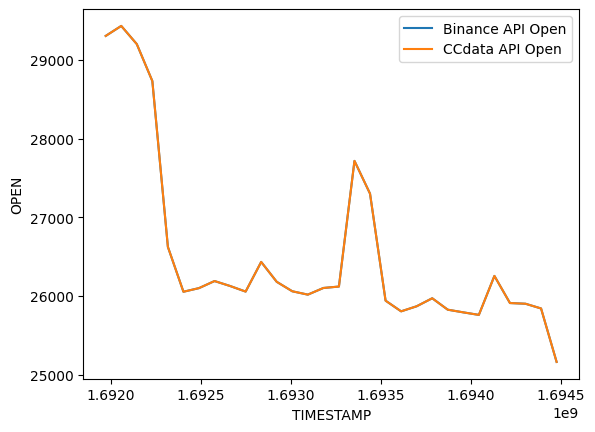

In [73]:
sns.lineplot(data=binanceapi_df, x='TIMESTAMP', y='OPEN', label='Binance API Open')
sns.lineplot(data=binance_df, x='TIMESTAMP', y='OPEN', label='CCdata API Open')

<AxesSubplot:xlabel='TIMESTAMP', ylabel='CLOSE'>

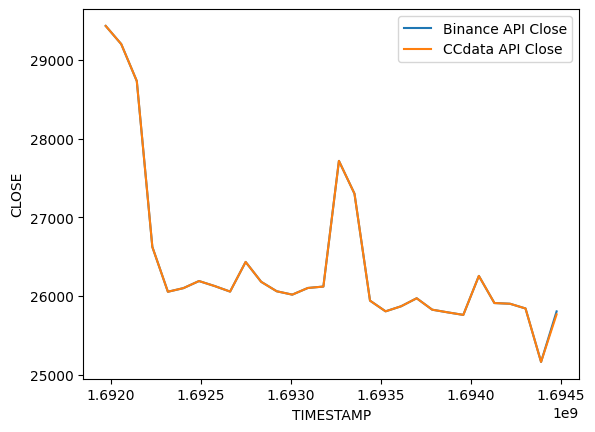

In [75]:
sns.lineplot(data=binanceapi_df, x='TIMESTAMP', y='CLOSE', label='Binance API Close')
sns.lineplot(data=binance_df, x='TIMESTAMP', y='CLOSE', label='CCdata API Close')